In [1]:
#Files for Min Hash Similarity Part

In [1]:
#Helper Functions
import random

# Calculate the Jaccard similarity of 2 sets
def jaccardSim(s1,s2):
    s1 = set(s1)
    s2 = set(s2)
    return (len(s1.intersection(s2)) / len(s1.union(s2)))


# Return a random hash function from a universal family
# p = prime number > m
def make_random_hash_function(p=2**33-355, m=2**32-1):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

In [2]:
# Read input file and preprocess data
import re
import string
from collections import defaultdict

class Parser():
    def parse_input_file(self, filename):
        data_list = []
        with open(filename) as ff:
            contents = ff.readlines()
            for line in contents:
                doc_id_word = ()
                # read all of the words (they are all in one line) and split them by white space
                words = line.split(" ")
                # retrieve the article ID which is the first word on the line
                docID = words[0]
                del(words[0])

                word_list = []
                for word in words:
                    # make words lowercase
                    word = word.lower()
                    # remove any tabs, new lines, e.t.c
                    word = re.sub(r'[^\w]','',word)
                    word_list.append(word)
                word_list = ''.join(word_list)
                doc_id_word = (docID,word_list)
                data_list.append(doc_id_word)
            return data_list

In [3]:
# Create proper data structures for our data
import numpy as np
import binascii
from time import time

hash_num = 10
shingles_len = 7

class ProcessData():
    def map_doc_id(self, docIds):
        docIdMap = {}
        for i in range(0, len(docIds)):
            docIdMap[docIds[i]] = i
        return docIdMap

    def invert_shingles(self,tuples,ids):
        # Compute the hash value for each of our word in document
        shingles_list= list()
        for d in data:
            hash_shingles = set()
            for i in range(0, len(d[1]) - shingles_len + 1):
                hash_value = binascii.crc32(d[1][i: i + shingles_len].encode('utf-8')) & 0xffffffff
                hash_shingles.add(hash_value)
            shingles_list.append((d[0],hash_shingles))
    
        # Invert shingles so shingles become rows and docId's become columns
        for row in shingles_list:
            ids.append(row[0])
            for s in row[1]:
                tuples.append((s,row[0]))
        return tuples,ids
    
    def add_hash_functions(self):
        hash_funcs = []
        # Make hash functions
        for i in range(0, hash_num):
            hash_funcs.append(make_random_hash_function())
        return hash_funcs
    
    def calc_signature_matrix(self, num_docs):
        tuples = []
        ids = []
        hash_funcs = []
        tuples,ids = self.invert_shingles(tuples,ids)
        hash_funcs = self.add_hash_functions()
         # Initialize signature matrix values to infinity
        sigmatrix = np.full([hash_num, num_docs], np.inf)
        #print('sigmatrix shape: ',sigmatrix.shape)
        doc_id_col_map = self.map_doc_id(ids)

        # Update signature matrix values
        row = 0
        for item, id in tuples:
            j = doc_id_col_map[id]
            for n in range(0, len(hash_funcs)):
                sigmatrix[n][j]= min(hash_funcs[n](item), sigmatrix[n][j])
        return sigmatrix, doc_id_col_map

# Min Hash Similarity Class
class MinHashSimilarity():  
    def CalculateSimilarity(self, num_docs):
        preprocess = ProcessData()
    
        sigmatrix,doc_id_col_map = preprocess.calc_signature_matrix(num_docs)
        
        # Compute similarity for signature matrix based on jaccard similarity
        sim_sets = []
        sigmatrix = np.array(sigmatrix)
        for i in range(0, sigmatrix.shape[1]-1):
            s1 = sigmatrix[:,i]
            for j in range(i + 1, sigmatrix.shape[1]):
                s2 = sigmatrix[:,j]
                sim = jaccardSim(s1,s2)
                if sim > 0.8:
                    d1Str = list(doc_id_col_map.keys())[i]
                    d2Str = list(doc_id_col_map.keys())[j]
                    sim_sets.append((d1Str,d2Str,round(sim,2)))
        return sim_sets


In [4]:
# Run the Min Hash algorithm on different size files, count their response timea and write output to a file
filename = "C:/Users/iTTaste/articles_100.txt"
parser = Parser()
data = parser.parse_input_file(filename)

min_hash_similarity = MinHashSimilarity()
start_time = time()
similarities = min_hash_similarity.CalculateSimilarity(len(data))
end_time = time()
est_time = end_time - start_time
if est_time > 60.0:
    print('Execution time for %d articles: %f minutes'%(len(data),est_time/60.0))
else:
    print('Execution time for %d articles: %f seconds'%(len(data),est_time))
    
# Write similar pair documents to a file
with open('MinHashSimilarDocuments.txt', 'w+') as fp:
    fp.write('Similarity between documents using the MinHash Method: \n')
    for sims in similarities:
        fp.write('\t'.join('%s' % s for s in sims))
        fp.write('')
        fp.write('\n')
fp.close()   

Execution time for 10000 articles: 18.694859 minutes


In [ ]:
# Files for Localiry Sensitive Hashing Similarity Part

In [5]:
# LSH algorithm (in order to run this we should run MinHash first to create signature matrix

import numpy as np
import binascii
from time import time

hash_num = 10
shingles_len = 7

class LSHSimilarity():
    def __init__(self, num_docs):
        self.num_docs = num_docs
    
    def hash_vector(self, hash_fns, vec, m=2**32-1):
        sum = 0
        for i in range(len(vec)):
            h = hash_fns[i]
            sum += h(vec[i])
        return sum % m

    def CalculateSimilarity(self, sigmatrix):
        preprocess = ProcessData()
        
        hash_funcs = preprocess.add_hash_functions()
        sigmatrix, doc_id_col_map = preprocess.calc_signature_matrix(self.num_docs)
        
        
        # Compute similarity for signature matrix based on jaccard similarity
        sim_sets = []
        sigmatrix = np.array(sigmatrix)


        # Initialize the number of bands and threshold
        bands_num = 2

        # Calculate number of rows needed for each band
        rows = int(hash_num / bands_num)

        s = pow((1/bands_num),1/rows)
        #print('rows threshold: ',rows,s)
        
        buckets = []
        bucket_dic = defaultdict(list)

        pairs = set()

        for r in range(bands_num):
            start_row = r * rows
            end_row = start_row + rows

            for doc in range(self.num_docs):
                hash_vec = self.hash_vector(hash_funcs,sigmatrix[start_row:end_row,doc])
                bucket_dic[hash_vec].append(doc)
                #print('bucket',bucket_dic.items())

        for item, value in bucket_dic.items():
            if len(value) > 1:
                pairs.add(tuple(value))

        sim_docs = []
        for s in pairs:
            d1 = list(doc_id_col_map.keys())[s[0]]
            d2 = list(doc_id_col_map.keys())[s[1]]
            sim_docs.append((d1,d2))

        # Get candidate pairs that hash to the same bucket at least once
        return sim_docs


In [ ]:
sigmatrix = []
start_time = time()
lsh_similarity = LSHSimilarity(len(data))
similarities = lsh_similarity.CalculateSimilarity(sigmatrix)
end_time = time()
est_time = end_time - start_time
if est_time > 60.0:
    print('Execution time for %d articles: %f minutes'%(len(data),est_time/60.0))
else:
    print('Execution time for %d articles: %f seconds'%(len(data),est_time))

In [22]:
# Write similar pair documents to a file
with open('LSHSimilarDocuments.txt', 'w+') as fp:
    fp.write('Similarity between documents using the LSH Method: \n')
    for sims in similarities:
        fp.write('\t'.join('%s' % s for s in sims))
        fp.write('')
        fp.write('\n')
fp.close()

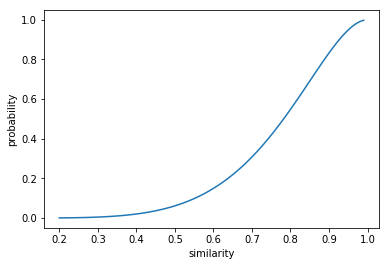

In [34]:
import matplotlib.pyplot as plt
import math
import numpy as np

b = 2
r = 5
prob = []
sim = [x for x in np.arange(0.2, 1.0, 0.01)]
for s in sim:
    prob.append((1-pow((1-pow(s,r)),b)))


# axis values 
x = sim
y = prob
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('similarity') 
# naming the y axis 
plt.ylabel('probability') 
  
# function to show the plot 
plt.show() 

